In [1]:
import numpy as np
import os
# matplotlib 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### 데이터 다운받기

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
X_train.shape
# y_train

(60000, 28, 28)

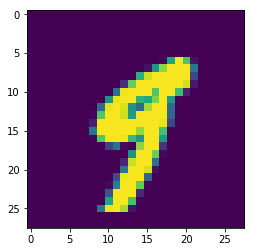

In [4]:
some_digit = X_train[36000]
some_digit
plt.imshow(some_digit)


X_train.shape # 60000, 28, 28(eigen vector로 이미 바꿈)
X_train = X_train.reshape(60000, 28*28)
X_train.shape

some_digit = X_train[36000]
# y_train.shape #1797

# y_train[36000]

In [5]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 이진분류기 훈련

In [6]:
y_train_9 = (y_train == 9) # 5는 true이고 나머지는 false
y_test_9 = (y_test == 9)
y_train_9

array([False, False, False, ..., False, False, False])

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.944  , 0.9388 , 0.94525])

In [9]:
from sklearn.base import BaseEstimator

class Never9Classfier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len (X), 1), dtype=bool)

In [10]:
never_9_clf = Never9Classfier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.8997 , 0.90105, 0.9018 ])

## 오차행렬 (CONFUSION MATRIX)

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3) # 점수 반환이 아니라 예측 반환

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52926,  1125],
       [ 2314,  3635]], dtype=int64)

## 정밀도(precision)과 재현율(recall)

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_9, y_train_pred)) # 9로 판별된 이미지 중에서 77퍼만 정확
print(recall_score(y_train_9, y_train_pred)) # 전체 숫자 9에서 57퍼만 감지

0.7636554621848739
0.6110270633719953


In [14]:
# 정밀도와 재현율을 조화평균으로 f1_score만듬
from sklearn.metrics import f1_score
f1_score(y_train_9, y_train_pred)

0.6788682416658885

## 각 샘플의 점수를 얻어 임곗값을 정해 예측을 만든다.

In [15]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [16]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3,
                            method="decision_function")
y_scores

array([ -837863.77223539,  -505294.95348506,  -716230.3810245 , ...,
        -841905.79608707,  -234509.63988731, -1510011.06029235])

### 모든 임곗값에 대해 정밀도와 재현율 계산

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

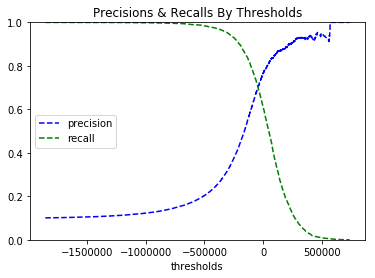

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("thresholds")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.title("Precisions & Recalls By Thresholds")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### 정밀도 90인 지점

In [19]:
y_trained_pred_90 = (y_scores > 80000)
print(precision_score(y_train_9, y_trained_pred_90))
print(recall_score(y_train_9, y_trained_pred_90))

0.8353293413173652
0.42208774583963693


### ROC(reciever operation characteristic) 곡선
#### 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)  = 1 - TNR(진짜 음성 비율)

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

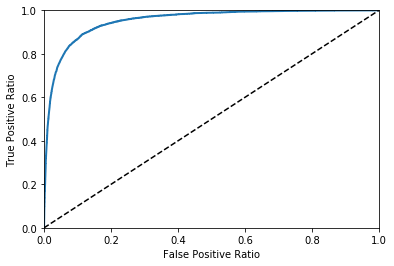

In [21]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')

plot_roc_curve(fpr, tpr)
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9523982472130199

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9,
                                    cv=3, method = "predict_proba")

In [24]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_9, y_scores_forest)

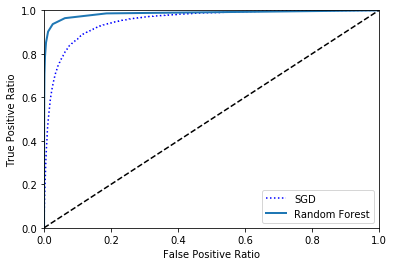

In [25]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
roc_auc_score(y_train_9, y_scores_forest)

0.9861149608306374

### 다중분류
#### one-versus-all, one-versus-the-rest 전략이라고 부름 하나를 전부와 구분
#### one versus one 하나를 하나와만 구분 (SVM에서 선호)

In [27]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

In [28]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-892946.77408442, -358862.30130815, -947529.83912258,
        -254885.70682884,  -77587.95834905, -100212.61549508,
        -807590.66081382, -316577.57247579, -314372.42098924,
        -276958.63043301]])

In [29]:
np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[4]

4

In [30]:
# sgd classfier ovo훈련
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([4], dtype=uint8)

In [31]:
len(ovo_clf.estimators_) # n * (n - 1) / 2

45

In [32]:
# random forest classfier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=uint8)

In [33]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.9]])

In [34]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8639772 , 0.83639182, 0.85887883])

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91066787, 0.90924546, 0.90988648])

### 에러분석

In [36]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5739,    5,   22,    8,   11,   41,   48,    9,   36,    4],
       [   1, 6471,   43,   26,    6,   49,    5,    8,  123,   10],
       [  61,   42, 5325,   87,   86,   23,   89,   66,  162,   17],
       [  53,   36,  133, 5321,    3,  239,   40,   54,  154,   98],
       [  21,   26,   31,    8, 5379,    8,   47,   30,   94,  198],
       [  67,   44,   35,  174,   78, 4603,  118,   23,  188,   91],
       [  27,   22,   42,    2,   41,   93, 5637,   10,   43,    1],
       [  21,   22,   73,   22,   53,   10,    7, 5825,   16,  216],
       [  52,  150,   66,  147,   17,  156,   59,   23, 5050,  131],
       [  43,   36,   26,   90,  167,   35,    3,  223,   80, 5246]],
      dtype=int64)

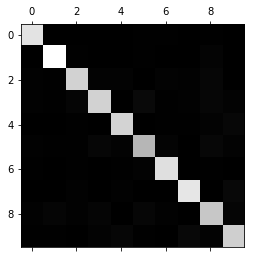

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [38]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

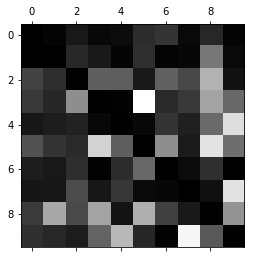

In [39]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# 8열 9열이 밝은 그림이 많음

In [40]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

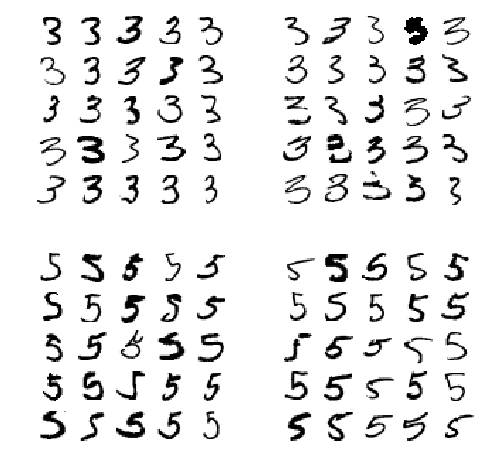

In [41]:
# 3과 5의혼돈 & 8, 9 제대로 분류 못함

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plot_digits
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.savefig("error_analysis_digits_plot")
plt.show()

### 다중레이블분류

In [42]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [43]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=2, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

### 다중 출력 분류

In [ ]:
noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train _ noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod= X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)